In [1]:
%pip install boto3

     ------------------------------------ 135.8/135.8 kB 348.6 kB/s eta 0:00:00
     ---------------------------------------- 11.1/11.1 MB 1.4 MB/s eta 0:00:00
  Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)
  Using cached s3transfer-0.6.1-py3-none-any.whl (79 kB)

[notice] A new release of pip available: 22.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
from sklearn.datasets import fetch_openml
import pandas as pd 
import matplotlib.pyplot as plt 

In [10]:
#load data 
mnist = fetch_openml('mnist_784',version=1)

In [11]:
mnist_data = (
    mnist.data.sample(
        n=20000,random_state=7,axis=0,replace=False
    )
)

In [12]:
#creating target varaible 
target = (
    mnist.target.loc[mnist_data.index].astype('uint8')
)

(-0.5, 27.5, 27.5, -0.5)

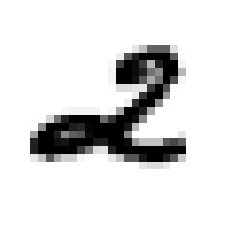

In [16]:
some_digit = (
    mnist_data.iloc[0]
    .values
    .reshape(28,28)
    .astype('float32')   
)
plt.imshow(some_digit,cmap='binary')
plt.axis('off')

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import cross_val_score
import numpy as np 

In [12]:
def train_knn_model(features,target):
    knn_model = KNeighborsClassifier(weights='distance',n_neighbors=4)
    knn_model.fit(features,target)
    scores = cross_val_score(
        knn_model,features,target,scoring='accuracy',cv=10)
    print(f'cross validation score - accuracy  :{scores}')
    print(f'average accuracy score : {np.mean(scores)}')
    return knn_model,scores 

In [15]:
train_features,test_features,train_targets,test_targets = train_test_split(
    mnist_data,target,test_size=0.2,random_state=7)

In [ ]:
model,scores = train_knn_model(train_features,train_targets)

In [27]:
import numpy as np 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [28]:
def show_cm(y_true,y_pred,labels):
    '''shows confusion matrix'''
    conf_mat = confusion_matrix(y_true,y_pred,labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=labels)
    score = accuracy_score(y_true,y_pred)
    print(f'Accuracy:{score}')
    disp.plot()

In [29]:
import joblib
model = joblib.load('./app/models/knn_model.joblib')

Accuracy:0.963


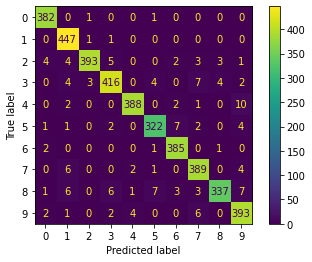

In [30]:
test_target_pred = model.predict(test_features)
#show confusion_matrix


In [31]:
#saving our model locally 
import joblib 
joblib.dump(model,'app\models\knn_model.joblib')

['models\\knn_model.joblib']

## Initialising the aws s3 bucket

In [33]:
import boto3 

def create_bucket(region,bucket_name):
    s3 = boto3.client('s3')
    response = s3.create_bucket(
        Bucket=bucket_name,
        CreateBucketConfiguration={
            'LocationConstraint':region
        }
    )
    return response 
region = 'eu-west-2'
bucket_name = 'mnist-lambda-bucket'
create_bucket(region,bucket_name)


{'ResponseMetadata': {'RequestId': 'S8XT8ABTYJEEWBJS',
  'HostId': 'BLXaKfWjYNgx/wdScLOLl1fCtknADMbjk44wighi/UVTvl+iOQsq5RhV+6DIKIbc78gaCCltRW8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'BLXaKfWjYNgx/wdScLOLl1fCtknADMbjk44wighi/UVTvl+iOQsq5RhV+6DIKIbc78gaCCltRW8=',
   'x-amz-request-id': 'S8XT8ABTYJEEWBJS',
   'date': 'Mon, 31 Jul 2023 08:30:21 GMT',
   'location': 'http://mnist-lambda-bucket.s3.amazonaws.com/',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'Location': 'http://mnist-lambda-bucket.s3.amazonaws.com/'}

In [39]:
#serializing the mnist dataset
from io import BytesIO
import joblib 
import boto3 

def uploadtoS3(data,bucket,key):
    with BytesIO() as f:
        joblib.dump(data,f)
        f.seek(0)
        (
            boto3.client('s3')
            .upload_fileobj(Bucket=bucket,Key=key,Fileobj=f)
        )

bucket_name='mnist-lambda-bucket'
key = 'validation/test-features.joblib'
uploadtoS3(test_features,bucket_name,key)

In [31]:
import boto3

def listS3Objects(bucket:str) -> list:

     # Connect to s3 resource
    s3 = boto3.resource('s3')
    my_bucket = s3.Bucket(bucket)

    # List all object keys in s3 bucket
    obj_list = [object_summary.key for object_summary in my_bucket.objects.all()]
    return obj_list

listS3Objects('mnist-lambda-bucket')

['validation/test-features.joblib']

## Connection to the local endpoint

Accuracy:0.963


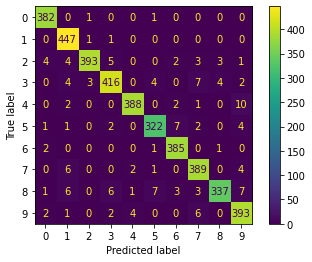

In [37]:
import requests 
import json 
import numpy as np 

bucket_name = 'mnist-lambda-bucket'
key = 'validation/test-features.joblib'

data = {
    'bucket':bucket_name,
    'key':key
}


headers = {
    'Content-type':'application/json'
}

#main code for post HTTP request 

url = 'https://l62ce503ke.execute-api.eu-west-1.amazonaws.com/dev/predict'
response = requests.request('POST',url,headers=headers,data=json.dumps(data))

lambda_predictions = np.array(response.json())
show_cm(test_targets, lambda_predictions, range(10))


In [33]:
!pip show pandas

Name: pandas
Version: 1.3.5
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: c:\users\user\.conda\envs\torch\lib\site-packages
Requires: numpy, python-dateutil, pytz
Required-by: category-encoders, datasets, fastai, gradio, mlflow, seaborn, stable-baselines3, statsmodels, zenml
